## Import packages

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    average_precision_score, confusion_matrix, log_loss, cohen_kappa_score,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import GridSearchCV, cross_val_score
from bayes_opt import BayesianOptimization

## Load data, making sure to drop the serial number column, which is not useful for classification

In [10]:
train_df = pd.read_csv('datasets/train.csv', index_col=0)
test_df = pd.read_csv('datasets/test.csv', index_col=0)

## Clean data

In [11]:
train_df.head()

,Tp,Cl,pH,Redox,Leit,Trueb,Cl_2,fm,Fm_2,EVENT
0,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1677.0,695.0,0
1,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1561.0,696.0,0
2,6.5,0.17,8.35,749.0,211.0,0.011,0.117,1581.0,696.0,0
3,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1579.0,693.0,0
4,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1567.0,689.0,0


### Columns that have only one unique value aren't useful to classification, and should be dropped

In [12]:
train_df['Tp'].unique()

array([6.5       , 6.6       , 6.7       , ..., 9.00663063, 8.41352575,
       8.22963054], shape=(31635,))

In [13]:
test_df.head()

,Tp,Cl,pH,Redox,Leit,Trueb,Cl_2,fm,Fm_2,EVENT
0,10.1,0.17,8.41,762.0,190.0,0.022,0.106,1818.0,920.0,0
1,10.1,0.18,8.41,762.0,190.0,0.022,0.106,1805.0,927.0,0
2,10.1,0.19,8.41,762.0,189.0,0.022,0.108,1787.0,927.0,0
3,10.1,0.18,8.41,762.0,190.0,0.022,0.108,1790.0,936.0,0
4,10.1,0.18,8.41,762.0,189.0,0.022,0.108,1827.0,924.0,0


In [14]:
test_df['EVENT'].unique()

array([0, 1])

## Check datatypes

In [15]:
train_df.dtypes

Tp       float64
Cl       float64
pH       float64
Redox    float64
Leit     float64
Trueb    float64
Cl_2     float64
fm       float64
Fm_2     float64
EVENT      int64
dtype: object

In [16]:
test_df.dtypes

Tp       float64
Cl       float64
pH       float64
Redox    float64
Leit     float64
Trueb    float64
Cl_2     float64
fm       float64
Fm_2     float64
EVENT      int64
dtype: object

## Format data for XGBoost

### Split test and training data into X_train, y_train, X_test, y_test

In [17]:
X_train = train_df.drop(columns=['EVENT']) # Features
y_train = train_df['EVENT'] # Labels
X_test = test_df.drop(columns=['EVENT'])
y_test = test_df['EVENT']

In [18]:
X_train.head()

,Tp,Cl,pH,Redox,Leit,Trueb,Cl_2,fm,Fm_2
0,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1677.0,695.0
1,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1561.0,696.0
2,6.5,0.17,8.35,749.0,211.0,0.011,0.117,1581.0,696.0
3,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1579.0,693.0
4,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1567.0,689.0


In [19]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: EVENT, dtype: int64

In [20]:
X_test.head()

,Tp,Cl,pH,Redox,Leit,Trueb,Cl_2,fm,Fm_2
0,10.1,0.17,8.41,762.0,190.0,0.022,0.106,1818.0,920.0
1,10.1,0.18,8.41,762.0,190.0,0.022,0.106,1805.0,927.0
2,10.1,0.19,8.41,762.0,189.0,0.022,0.108,1787.0,927.0
3,10.1,0.18,8.41,762.0,190.0,0.022,0.108,1790.0,936.0
4,10.1,0.18,8.41,762.0,189.0,0.022,0.108,1827.0,924.0


In [21]:
y_test.head()

0    0
1    0
2    0
3    0
4    0
Name: EVENT, dtype: int64

## Build initial model with early stopping

In [22]:
start_time = time.time()

model = xgb.XGBClassifier(objective="binary:logistic", missing=np.nan, seed=42, early_stopping_rounds=10, eval_metric='aucpr', verbosity=1)

In [23]:
model.fit(X_train, y_train, verbose=True, eval_set=[(X_test, y_test)])

end_time = time.time()

# Calculate training time
training_time = end_time - start_time

# Print the training time
print(f"Training time: {training_time:.4f} seconds")

[0]	validation_0-aucpr:0.07407
[1]	validation_0-aucpr:0.07642
[2]	validation_0-aucpr:0.09512
[3]	validation_0-aucpr:0.09038
[4]	validation_0-aucpr:0.20048
[5]	validation_0-aucpr:0.22645
[6]	validation_0-aucpr:0.12716
[7]	validation_0-aucpr:0.21921
[8]	validation_0-aucpr:0.21260
[9]	validation_0-aucpr:0.18979
[10]	validation_0-aucpr:0.20664
[11]	validation_0-aucpr:0.20412
[12]	validation_0-aucpr:0.21504
[13]	validation_0-aucpr:0.21433
[14]	validation_0-aucpr:0.22630
[15]	validation_0-aucpr:0.22953
[16]	validation_0-aucpr:0.23742
[17]	validation_0-aucpr:0.24217
[18]	validation_0-aucpr:0.24636
[19]	validation_0-aucpr:0.26029
[20]	validation_0-aucpr:0.24466
[21]	validation_0-aucpr:0.25721
[22]	validation_0-aucpr:0.25414
[23]	validation_0-aucpr:0.26390
[24]	validation_0-aucpr:0.26742
[25]	validation_0-aucpr:0.26995
[26]	validation_0-aucpr:0.27085
[27]	validation_0-aucpr:0.26311
[28]	validation_0-aucpr:0.27310
[29]	validation_0-aucpr:0.27127
[30]	validation_0-aucpr:0.27279
[31]	validation_0-

## Get predictions from model

In [24]:
y_pred = model.predict(X_test)

## Plot confusion matrix

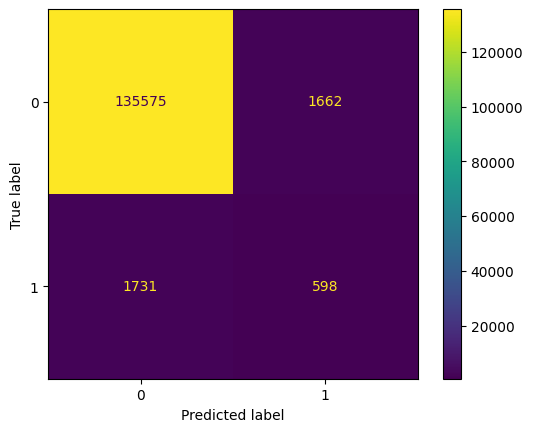

In [25]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Get other metrics

In [26]:
y_pred_proba = model.predict_proba(X_test)[:, 1] # Probabilities for positive class only

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print("ROC-AUC: ", roc_auc_score(y_test, y_pred_proba))
print("PR-AUC (Average Precision): ", average_precision_score(y_test, y_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred, labels=[0,1]))
print("Log Loss: ", log_loss(y_test, y_pred_proba))
print("Cohen's Kappa: ", cohen_kappa_score(y_test, y_pred))

Accuracy:  0.9756889213705344
Precision:  0.2646017699115044
Recall:  0.2567625590382138
F1 Score:  0.26062322946175637
ROC-AUC:  0.7114238144964975
PR-AUC (Average Precision):  0.2756817015227641
Confusion Matrix:
 [[135575   1662]
 [  1731    598]]
Log Loss:  0.10097984959400425
Cohen's Kappa:  0.24826735044932613


## Optimize hyper parameters using Bayesian Optimization and Cross Validation

### Round 1

In [69]:
# Function to optimize
def xgb_cv(gamma, learning_rate, max_depth, reg_lambda, scale_pos_weight):
    model = xgb.XGBClassifier(
        n_estimators=100,
        gamma=gamma,
        learning_rate=learning_rate,
        max_depth=int(max_depth),  # Must be integer
        reg_lambda=reg_lambda,
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')
    return scores.mean()

In [70]:
param_grid = {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3),
    'gamma': (0, 5),
    'reg_lambda': (0, 10),
    'scale_pos_weight': (1, 10)
}

In [71]:
optimizer = BayesianOptimization(
    f=xgb_cv,
    pbounds=param_grid,
    random_state=42,
    verbose=2
)

optimizer.maximize(
    init_points=5,
    n_iter=15
)

# Print best result
print("Best result:", optimizer.max)

|   iter    |  target   |   gamma   | learni... | max_depth | reg_la... | scale_... |
-------------------------------------------------------------------------------------


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:12:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:12:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:12:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 1         | 0.9969    | 1.873     | 0.2857    | 8.124     | 5.987     | 2.404     |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:12:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:12:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:12:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 2         | 0.9872    | 0.78      | 0.02684   | 9.063     | 6.011     | 7.373     |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:12:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:12:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:12:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 3         | 0.9958    | 0.1029    | 0.2913    | 8.827     | 2.123     | 2.636     |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:12:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:12:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:13:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 4         | 0.9948    | 0.917     | 0.09823   | 6.673     | 4.319     | 3.621     |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:13:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:13:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:13:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 5         | 0.9878    | 3.059     | 0.05045   | 5.045     | 3.664     | 5.105     |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:13:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:13:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:13:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 6         | 0.9966    | 0.0       | 0.3       | 8.093     | 4.745     | 1.0       |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:13:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:13:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:13:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 7         | 0.9976    | 0.2632    | 0.3       | 6.164     | 8.969     | 1.0       |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:13:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:14:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:14:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 8         | 0.9939    | 2.65      | 0.3       | 10.0      | 10.0      | 1.0       |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:14:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:14:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:14:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 9         | 0.9933    | 2.642     | 0.3       | 3.0       | 10.0      | 1.0       |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:14:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:14:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:14:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 10        | 0.996     | 0.2076    | 0.2854    | 4.72      | 5.601     | 1.048     |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:14:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:14:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:14:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 11        | 0.9936    | 4.443     | 0.3       | 10.0      | 2.973     | 1.0       |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:14:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:14:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:14:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 12        | 0.9974    | 0.0       | 0.3       | 5.469     | 0.0       | 1.0       |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:15:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:15:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:15:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 13        | 0.9932    | 0.0       | 0.3       | 3.0       | 0.0       | 1.0       |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:15:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:15:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:16:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 14        | 0.9672    | 1.603     | 0.01      | 7.735     | 0.0       | 1.0       |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:16:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:16:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:16:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 15        | 0.9977    | 0.6679    | 0.2238    | 5.109     | 1.895     | 3.042     |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:16:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:16:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:16:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 16        | 0.9914    | 1.357     | 0.199     | 3.435     | 7.471     | 9.633     |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:16:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:16:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:16:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 17        | 0.9954    | 4.697     | 0.1226    | 9.953     | 3.143     | 1.033     |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:16:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:16:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:16:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 18        | 0.9965    | 0.0       | 0.3       | 4.73      | 0.6744    | 2.317     |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:16:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:16:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:16:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 19        | 0.9976    | 0.5485    | 0.2872    | 6.817     | 6.852     | 1.397     |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:16:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:16:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:16:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 20        | 0.9952    | 1.923     | 0.2456    | 7.163     | 8.352     | 1.912     |
Best result: {'target': np.float64(0.9977401535112542), 'params': {'gamma': np.float64(0.6679367840339473), 'learning_rate': np.float64(0.22380549354175328), 'max_depth': np.float64(5.109427007147007), 'reg_lambda': np.float64(1.895342692941816), 'scale_pos_weight': np.float64(3.041727750456581)}}


In [72]:
start_time = time.time()
optimized_model = xgb.XGBClassifier(
    seed=42,
    objective='binary:logistic',
    gamma=0.6679367840339473,
    learning_rate=0.22380549354175328,
    max_depth=5,
    reg_lambda=1.895342692941816,
    scale_pos_weight=3.041727750456581,
    subsample=0.9,
    colsample_bytree=0.5,
    early_stopping_rounds=10,
    eval_metric='auc',
)

In [73]:
optimized_model.fit(X_train, y_train, verbose=True, eval_set=[(X_test, y_test)])

end_time = time.time()

# Calculate training time
training_time = end_time - start_time

# Print the training time
print(f"Training time: {training_time:.4f} seconds")

[0]	validation_0-auc:0.74432
[1]	validation_0-auc:0.59258
[2]	validation_0-auc:0.59371
[3]	validation_0-auc:0.67753
[4]	validation_0-auc:0.64662
[5]	validation_0-auc:0.69390
[6]	validation_0-auc:0.70295
[7]	validation_0-auc:0.73188
[8]	validation_0-auc:0.72670
[9]	validation_0-auc:0.72654
[10]	validation_0-auc:0.72651
Training time: 5.9377 seconds


In [66]:
y_pred = optimized_model.predict(X_test)

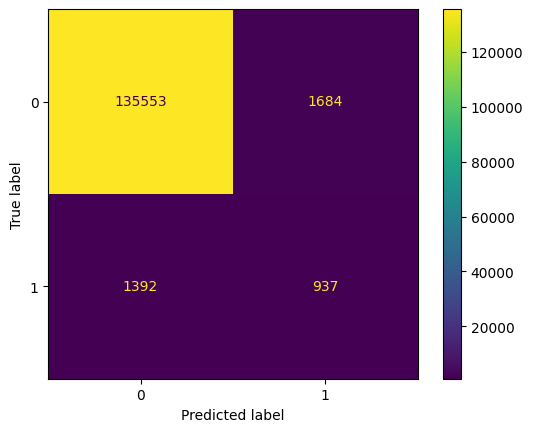

In [67]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
y_pred_proba = optimized_model.predict_proba(X_test)[:, 1] # Probabilities for positive class only

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print("ROC-AUC: ", roc_auc_score(y_test, y_pred_proba))
print("PR-AUC (Average Precision): ", average_precision_score(y_test, y_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred, labels=[0,1]))
print("Log Loss: ", log_loss(y_test, y_pred_proba))
print("Cohen's Kappa: ", cohen_kappa_score(y_test, y_pred))

Accuracy:  0.9779602481979852
Precision:  0.35749713849675696
Recall:  0.40231859167024475
F1 Score:  0.3785858585858586
ROC-AUC:  0.7114238144964975
PR-AUC (Average Precision):  0.2756817015227641
Confusion Matrix:
 [[135553   1684]
 [  1392    937]]
Log Loss:  0.10097984959400425
Cohen's Kappa:  0.36740677480301787
